# Homogenisation example

First run the example to train and save the trained model
```shell
cd ./examples/n_scale_potential
python n_scale_potential.py -m target.eps=0.01,0.05,0.1,0.5,1.0,2.0,5.0
```

The results will be saved to a path in `./outputs/multirun/...` that appropriately time-stamped.

The rest of the notebook will perform checking analysis on the outputs.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import os
import equinox as eqx
from n_scale_potential import build_model
from omegaconf import OmegaConf

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Load saved configuration and models

In [2]:
path = "outputs/multirun/2024_09_15-20_22_46"
num_runs = len(os.listdir(path)) - 1

configs = []
models = []

for run in range(num_runs):
    run_path = os.path.join(path, f"{run}")
    configs.append(OmegaConf.load(os.path.join(run_path, ".hydra", "config.yaml")))
    model = build_model(configs[-1])
    model = eqx.tree_deserialise_leaves(os.path.join(run_path, "model.eqx"), model)
    models.append(model)

## Check potential

First, we check if the homogenised potential function has been correctly recovered (up to additive constants).

In [3]:
from n_scale_potential import V_homogenised

In [4]:
x = np.linspace(-1.5, 1.5, 100)
v_x_true = V_homogenised(x)
v_x_true = v_x_true - v_x_true.min()

Text(0, 0.5, 'Mean squared error')

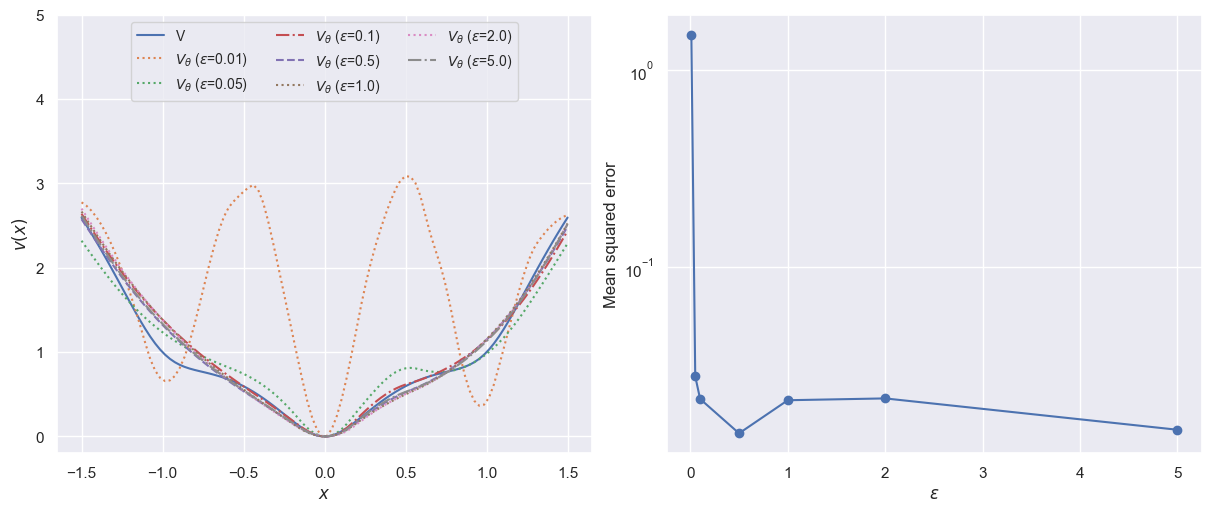

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

ax1.plot(x, v_x_true, label="V")

line_types = [":", ":", "-.", "--"]

errors = []

for i, (model, config) in enumerate(zip(models, configs)):
    v_x_pred = jax.vmap(model.potential, in_axes=(0, None))(x[:, None], [config.temperature])
    v_x_pred = v_x_pred - v_x_pred.min()
    errors.append(np.mean((v_x_pred - v_x_true)**2))
    ax1.plot(x, v_x_pred, line_types[i % len(line_types)], label=rf"$V_\theta$ ($\epsilon$={config.data.eps})")

ax1.legend(ncol=3, prop={"size": 10}, loc="upper center")
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$v(x)$")
ax1.set_ylim(-0.2, 5.0)

ax2.semilogy([config.data.eps for config in configs], errors, "o-")
ax2.set_xlabel(r"$\epsilon$")
ax2.set_ylabel("Mean squared error")

# fig.savefig("homogenised_potential_comparison.pdf", bbox_inches="tight")

# Check dissipation matrix

Next, we check that the dissipation matrix $M(x)$ has been correctly recovered.

In [6]:
from n_scale_potential import M_homogenised

Text(0, 0.5, 'Mean squared error')

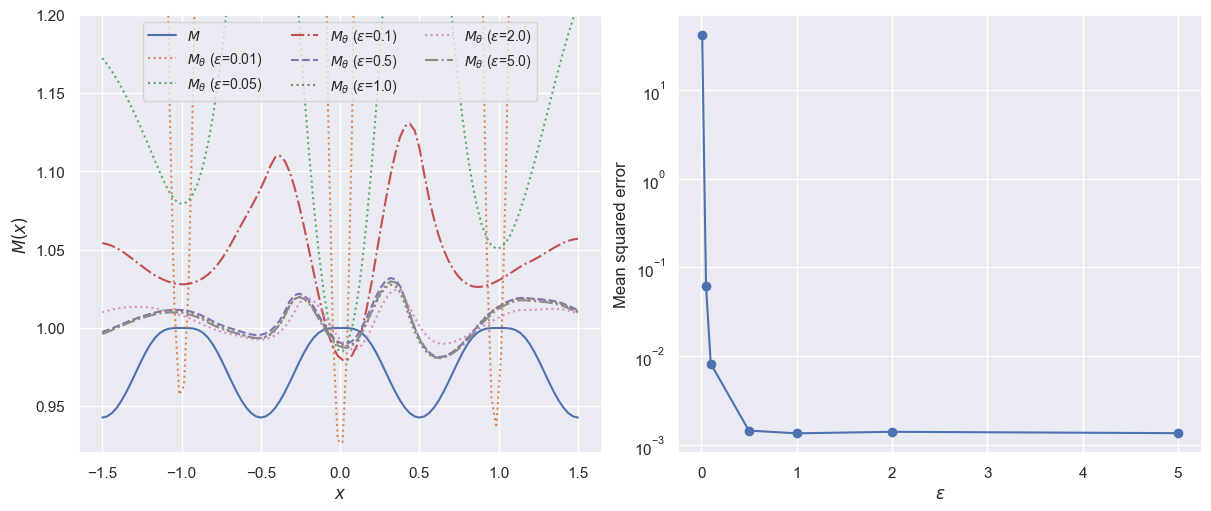

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

M_x_true = M_homogenised(x)
ax1.plot(x, M_x_true, label=r"$M$")

errors = []

for i, (model, config) in enumerate(zip(models, configs)):
    M_x_predicted = np.squeeze(jax.vmap(model.dissipation)(x[:, None]))
    errors.append(np.mean((M_x_predicted - M_x_true)**2))
    ax1.plot(x, M_x_predicted, line_types[i % len(line_types)], label=rf"$M_\theta$ ($\epsilon$={config.data.eps})")


ax1.legend(ncol=3, prop={'size': 10}, loc="upper center")

ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$M(x)$")


ax2.semilogy([config.data.eps for config in configs], errors, "o-")

ax1.set_ylim(.92, 1.2)

ax2.set_xlabel(r"$\epsilon$")
ax2.set_ylabel("Mean squared error")

# fig.savefig("homogenised_dissipation_comparison.pdf", bbox_inches="tight")